In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 

In [2]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

from d2l import torch as d2l

In [3]:
batch_size,num_steps = 32,35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [6]:
print(vocab,len(vocab))
F.one_hot(torch.tensor([0,  2]),len(vocab))

<d2l.torch.Vocab object at 0x000001F238897DA0> 28


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [12]:
X = torch.arange(10).reshape(2, 5)
print(F.one_hot(X, 28).shape)


torch.Size([2, 5, 28])


In [7]:
# 8.5.2 初始化模型参数

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加参数
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [21]:
# 8.5.3 循环神经网络模型
def init_rnn_state(batch_size, hidden_size,device):
    return (torch.zeros(batch_size, hidden_size, device=device),)

In [15]:
def rnn(inputs, state, params):
    # inputs 的形状为(时间步数, batch_size, 词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state  # 隐藏状态的初始值
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)   # 更新隐藏状态
        Y = torch.mm(H, W_hq) + b_q  # 输出层
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H,)  # 输出序列和隐藏状态

In [16]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [22]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens,d2l.try_gpu(), get_params, init_rnn_state, rnn)

state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
print(Y.shape, len(new_state), new_state[0].shape)


torch.Size([10, 28]) 1 torch.Size([2, 512])


In [23]:
def predict_ch8(prefix,num_preds,net,vocab,device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(1, 1)
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [24]:
predict_ch8('time traveller ',10,net,vocab,d2l.try_gpu())

'time traveller sqtyuiwyee'

In [25]:
def grad_clipping(net,theta): #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [ ]:
# 8.5.6 训练

def train_epoch_ch8(net, train_iter, loss, updater,device,use_random_iter):
    """训练网络一轮(定义见第8章)"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化隐藏状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 对于 nn.GRU 和 nn.LSTM，state 是个张量
                state.detach_()
            else:
                # state 对于nn.LSTM或对于我们从零开始实现的模型是个由张量组成的元组
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数，所以不需要除以y.numel()
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [27]:
#@save 
def train_ch8(net, train_iter, vocab, lr, num_epochs,device,use_random_iter=False):
    """训练模型(定义见第8章)"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

NameError: name 'Timer' is not defined

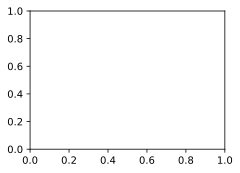

In [28]:
num_epochs,lr = 500,1
train_ch8(net,train_iter,vocab,lr,num_epochs,d2l.try_gpu())